# 图像处理应用-照片红眼修正

In [1]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

In [2]:
def fillHoles(mask):
    """Fill potential holes in a generated mask."""
    maskFloodFill = mask.copy()
    h, w = maskFloodFill.shape[:2]
    maskTemp = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(maskFloodFill, maskTemp, (0, 0), 255)
    mask2 = cv2.bitwise_not(maskFloodFill)
    return mask2 | mask

In [29]:
def redeye_fixing(src):
    rows,cols = src.shape[0],src.shape[1]
    rgb = np.float64(src)
    dst = rgb.copy()
    
    for i in range(rows):
        for j in range(cols):
            r = rgb[i,j,0]
            g = rgb[i,j,1]
            b = rgb[i,j,2]
            
            if r > (g + b):
                rc = (g + b )/ 2
                gc = (g + rc) / 2
                bc = (b + rc) / 2
                dst[i,j,0] = rc
                dst[i,j,1] = gc
                dst[i,j,2] = bc
                
    return cv2.convertScaleAbs(dst)

In [51]:
def redeye_remove(img):
    # Create an image copy
    imgOut = img.copy()

    # Load HAAR cascades
    faceCascade = cv2.CascadeClassifier("../datas/haarcascade_frontalface_default.xml")
    eyesCascade = cv2.CascadeClassifier("../datas/haarcascade_eye.xml")

    # Detect faces in the image
    gray = cv2.cvtColor(imgOut, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.3, 5)
    
    for (x,y,w,h) in faces:
#         if draw_boxes:
#             cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)

        # Make both gray and color copies of the face region
        roiGray = gray[y:y+h, x:x+w]
        roiColor = img[y:y+h, x:x+w]

        # Detect eyes on the face
        eyes = eyesCascade.detectMultiScale(roiGray)
        for (ex, ey, ew, eh) in eyes:
#             if draw_boxes:
#                 cv2.rectangle(roiColor, (ex,ey), (ex+ew,ey+eh), (0,255,0), 2)
#             # Extract the individual eye from the larger image
            eye = imgOut[(y + ey):(y + ey+eh), (x + ex) :(x + ex+ew) ]
    
            # Split colors into RGB
            b = eye[:, :, 0]
            g = eye[:, :, 1]
            r = eye[:, :, 2]

            # Combine green and blue
            bg = cv2.add(b, g)

            # Red eye mask
            mask = (r > 120) & (r > (bg)*2.6)

            # Convert the mask format
            mask = mask.astype(np.uint8)*255

            # Clean up the mask by filling holes and dilating
            mask = fillHoles(mask)
            mask = cv2.dilate(mask, None, anchor=(-1, -1), iterations=3, borderType=1, borderValue=1)

            # Average the blue and green values
            mean = bg//2
            mask = mask.astype(np.bool)[:, :, np.newaxis]
            mean = mean[:, :, np.newaxis]

            # Copy the eye from the original image
            eyeOut = eye.copy()

            # Copy an averaged eye to the output
            np.copyto(eyeOut, mean, where=mask)

            # Merge the new eye into the output image
#             fixed = redeye_fixing(eye)
            imgOut[(y + ey):(y + ey+eh), (x + ex) :(x + ex+ew) ] = eyeOut
    return imgOut

In [61]:
img = cv2.imread('../datas/red_eye_biolog.jpg')
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [62]:
dst = redeye_remove(img)
dst = cv2.cvtColor(dst,cv2.COLOR_BGR2RGB)

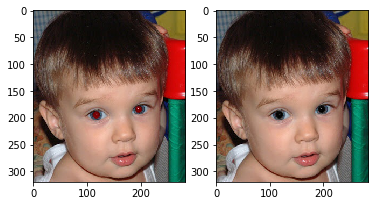

In [63]:
plt.subplot(121)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(dst)